In [1]:
%matplotlib inline
import os
import cPickle as pkl
import numpy as np
import pandas as pd
import colorsys
import matplotlib.colors as mc
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
import matplotlib.patheffects as path_effects
import seaborn as sns
import common.metrics as met
import common.plots as plo
import logging
import lasagne_nn.log_parser as lp
import json
from itertools import izip
from common.plot_fcns import *

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# data handling

def get_preds(dset_dict, expt, dset, fold, ratio=None):
    indir = data_dict[expt]["indir"]
    if ratio is not None:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, ratio, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, ratio, dset, fold)
    else:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, dset, fold)
        
    prediction = np.load(preds_file)
    truth = np.load(knowns_file)
    
    if dset_dict[expt]["npz_fmt"] == True:
        prediction = prediction["arr_0"]
        truth = truth["arr_0"]
        
    return prediction, truth

def predictions_knowns_from_trained_network_and_data(hdf5_file, weights_filename, build_nn_script,
                                                     test_indices_file=None,
                                                     npKi=False, multitask=False,
                                                     network_target_map_file=None,
                                                     dataset_target_map_file=None):
    network = get_network_from_weights(weights_filename, build_nn=build_nn_script)
    network_target_map = load_target_map(network_target_map_file) if network_target_map_file else None
    data_loader = H5pyDataLoader(hdf5_file=hdf5_file, test_indices_file=test_indices_file,
                                 npKi=npKi, multitask=multitask,
                                 target_map_file=dataset_target_map_file,
                                 train_percentage=None)
    data_loader.load_training_data()
    predictions, knowns = get_predictions_of_knowns(data_loader=data_loader,
                                                    weights_filename=weights_filename,
                                                    indices=data_loader.train_indices,
                                                    network=network,
                                                    network_target_map=network_target_map)
    return predictions, knowns

In [3]:
def get_preds(data_dict, expt, dset, fold, ratio=None):
    indir = data_dict[expt]["indir"]
    if ratio is not None:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, ratio, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, ratio, dset, fold)
    else:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, dset, fold)
        
    prediction = np.load(preds_file)
    truth = np.load(knowns_file)
    
    if data_dict[expt]["npz_fmt"] == True:
        prediction = prediction["arr_0"]
        truth = truth["arr_0"]
        
    return prediction, truth

In [4]:
def get_preds_regression(data_dict, expt, dset, fold, ratio=None):
    indir = data_dict[expt]["indir"]
    if ratio is not None:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, ratio, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, ratio, dset, fold)
    else:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, dset, fold)
        
    prediction = np.load(preds_file)
    truth = np.load(knowns_file)
    
    if data_dict[expt]["npz_fmt"] == True:
        prediction = prediction["arr_0"]
        truth = truth["arr_0"]
        
    return prediction, truth


In [5]:
def get_kde_dataframe(expts, data_dict, set_ratio=None, dset="drugmatrix"):
    new_df = pd.DataFrame({"prediction":[], "truth": [], "expt":[], "dset":[], "fold":[]})
    for e in expts:
        for fold in np.arange(0,5,1):
            ratio = None
            if set_ratio is not None:
                ratio = set_ratio
            if not set_ratio and "scrambled" in e:
                ratio = "1.0"
            prediction, truth = get_preds(data_dict, e, dset, fold, ratio=ratio)
            tmp = pd.DataFrame({"prediction": prediction.ravel().copy(), "truth": truth.ravel().copy(), "expt":e, "dset": dset, "fold": fold})
            new_df = new_df.append(tmp)
    return new_df

In [6]:
reg_data_file = "../regression/regression_preds_file_lookup.pkl"
with open(reg_data_file, "rb") as f:
    reg_data_dict = pkl.load(f)

In [7]:
class_data_file = "../classification/classification_preds_file_lookup.pkl"
with open(class_data_file, "rb") as f:
    class_data_dict = pkl.load(f)

In [8]:
with open("../regression/color_dict_pt.pkl", "rb") as f: 
    color_dict_pt = pkl.load(f)
with open("../regression/color_dict_bar.pkl", "rb") as f: 
    color_dict_bar = pkl.load(f)

In [9]:
expt_color_lookup = {
"NEG_RM": "NEG_RM",
"STD": "STD",
"NEG_RM_SMA": "NEG_RM_SMA",
'NEG_RM_RATIOS': "NEG_RM_SMA",
"STD_SMA": "STD_SMA",
"scrambled_idx": "scrambled_idx",
"scrambled_idx_LC": "scrambled_idx",
"SEA_SMA": "SEA_SMA",
"scrambled_idx_no_SMA": "scrambled_idx_no_SMA",
"scrambled_idx_no_SMA_LC": "scrambled_idx_no_SMA",
"CLASSIFIER_SEA_SMA": "SEA_SMA",
"CLASSIFIER_NEG_RM_SMA_RATIOS":  "NEG_RM_SMA",
"CLASSIFIER_SMA_RATIOS": "STD_SMA",
"CLASSIFIER_scrambled_idx_LC": "scrambled_idx",
"CLASSIFIER_scrambled_idx_No_SMA_LC": "scrambled_idx_no_SMA",
"CLASSIFIER_STD": "STD", 
"NEG_RM_scrambled": "NEG_UW", 
"NEG_RM_RATIOS_scrambled": "SEA_SMA",
'CLASSIFIER_NEG_RM_scrambled' : "NEG_UW",
'CLASSIFIER_NEG_RM_RATIOS_scrambled': "SEA_SMA",
'CLASSIFIER_NEG_RM': 'NEG_RM',
'NEG_UW': 'NEG_UW',
'CLASSIFIER_SEA_SMA_LR03': 'SEA_SMA'}

expt_legend_lookup = {
"NEG_RM": "Negatives Removed",
"NEG_UW" : "Negatives Upweighted",
"STD": "STD",
"NEG_RM_SMA": "Negatives Removed +SNA",
"STD_SMA": "SNA",
"scrambled_idx_LC": "SNA scrambled",
"SEA_SMA": "SNA +SEA blacklist",
"scrambled_idx_no_SMA_LC": "STD scrambled",
"CLASSIFIER_SEA_SMA": "SNA +SEA blacklist (classifier)",
"CLASSIFIER_NEG_RM_SMA_RATIOS":  "Negatives Removed +SNA (classifier)",
"CLASSIFIER_SMA_RATIOS": "SNA (classifier)",
"CLASSIFIER_scrambled_idx_LC": "SNA scrambled (classifier)",
"CLASSIFIER_scrambled_idx_No_SMA_LC": "STD scrambled (classifier)",
"CLASSIFIER_STD": "STD (classifier)", 
"NEG_RM_scrambled": "Negatives Removed scrambled", 
"NEG_RM_RATIOS_scrambled": "Negatives Removed +SNA scrambled",
'CLASSIFIER_NEG_RM_scrambled' : "Negatives Removed scrambled (classifier)",
'CLASSIFIER_NEG_RM_RATIOS_scrambled': "Negatives Removed +SNA scrambled (classifier)",
'CLASSIFIER_NEG_RM': 'Negatives Removed (classifier)', 
'CLASSIFIER_SEA_SMA': 'SNA +SEA blacklist (classifier)'}


class_expts = ["CLASSIFIER_scrambled_idx_No_SMA_LC", "CLASSIFIER_scrambled_idx_LC","CLASSIFIER_STD", "CLASSIFIER_SMA_RATIOS", ]
class_kde_df = get_kde_dataframe(class_expts, class_data_dict, set_ratio=1.0)
reg_expts = ["scrambled_idx_no_SMA", "scrambled_idx", "STD", "STD_SMA", ]
reg_kde_df = get_kde_dataframe(reg_expts, reg_data_dict, set_ratio=None)

In [10]:
class_cmaps = [(i, sns.light_palette(color_dict_bar[expt_color_lookup[i]], as_cmap=True)) for i in class_expts]
reg_cmaps = [(i, sns.light_palette(color_dict_bar[i], as_cmap=True)) for i in reg_expts]

In [11]:
def plot_kde_comp(df, cmap_map, title=None, shade=True, shade_lowest=False, figsize=(10,10), save_name=None, ):
    # Set up the figure
    f, ax = plt.subplots(figsize=figsize)
    tmp_df = df.copy()
    tmp_df_mask = ~df.truth.isna()
    tmp_df = tmp_df[tmp_df_mask]

    for e, cmap in cmap_map:
    # Draw the two density plots
        inner_tmp = tmp_df[tmp_df.expt==e]
        ax = sns.kdeplot(inner_tmp.truth, inner_tmp.prediction, color=cmap, shade=shade, 
                         shade_lowest=shade_lowest, lw=20.0)
    return f, ax

In [12]:
def rename_vals(df, expt_lookup_dict=expt_legend_lookup):
    # rename expts
    if expt_lookup_dict: 
        df.expt=df.expt.map(expt_lookup_dict)
    # and dsets
    df.dset[df.dset == "drugmatrix"] = "Drug Matrix"
    df.dset[df.dset == "timesplit"] = "Time Split"
    df.dset[df.dset == "test"] = "Test"
    df.dset[df.dset == "train"] = "Train" 
    return df

In [13]:
plot_data_save_base = "{}/20190410_SMA_Investigation/plot_data".format(get_env_var("DATA_SAVE_BASE"))

In [14]:
reg_df = pd.read_csv("{}/regression/neighbors_plot_vals.tsv".format(plot_data_save_base), sep='\t')

In [15]:
class_df = pd.read_csv("{}/classification/neighbors_plot_vals.tsv".format(plot_data_save_base), sep='\t')

In [16]:
reg_df["type"] = "regression"
reg_df["style"] = "d"
class_df["type"] = "classification"
reg_df["style"] = "+"

In [17]:
reg_df_tmp = reg_df.copy()
reg_df_tmp = reg_df_tmp[[u'Unnamed: 0', u'expt', u'dset', u'fold', u'ratio', u'AUROC', u'AUPRC',
        u'type', u'style']]


In [18]:
df = pd.concat([reg_df_tmp, class_df])
df = df.drop("ratio", axis=1)
df = df.drop("Unnamed: 0", axis=1)

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [19]:
dset_ymin_lookup = {'Drug Matrix':0.0, 'Time Split': 0.4, 'Test':0.4, 'Train':0.6}

In [20]:
labelsize=35
titlesize=40
save_dir = "{}/final_paper_figs".format(get_env_var("HOME"))

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/home/ecaceres/anaconda2/envs/features/lib/pyth

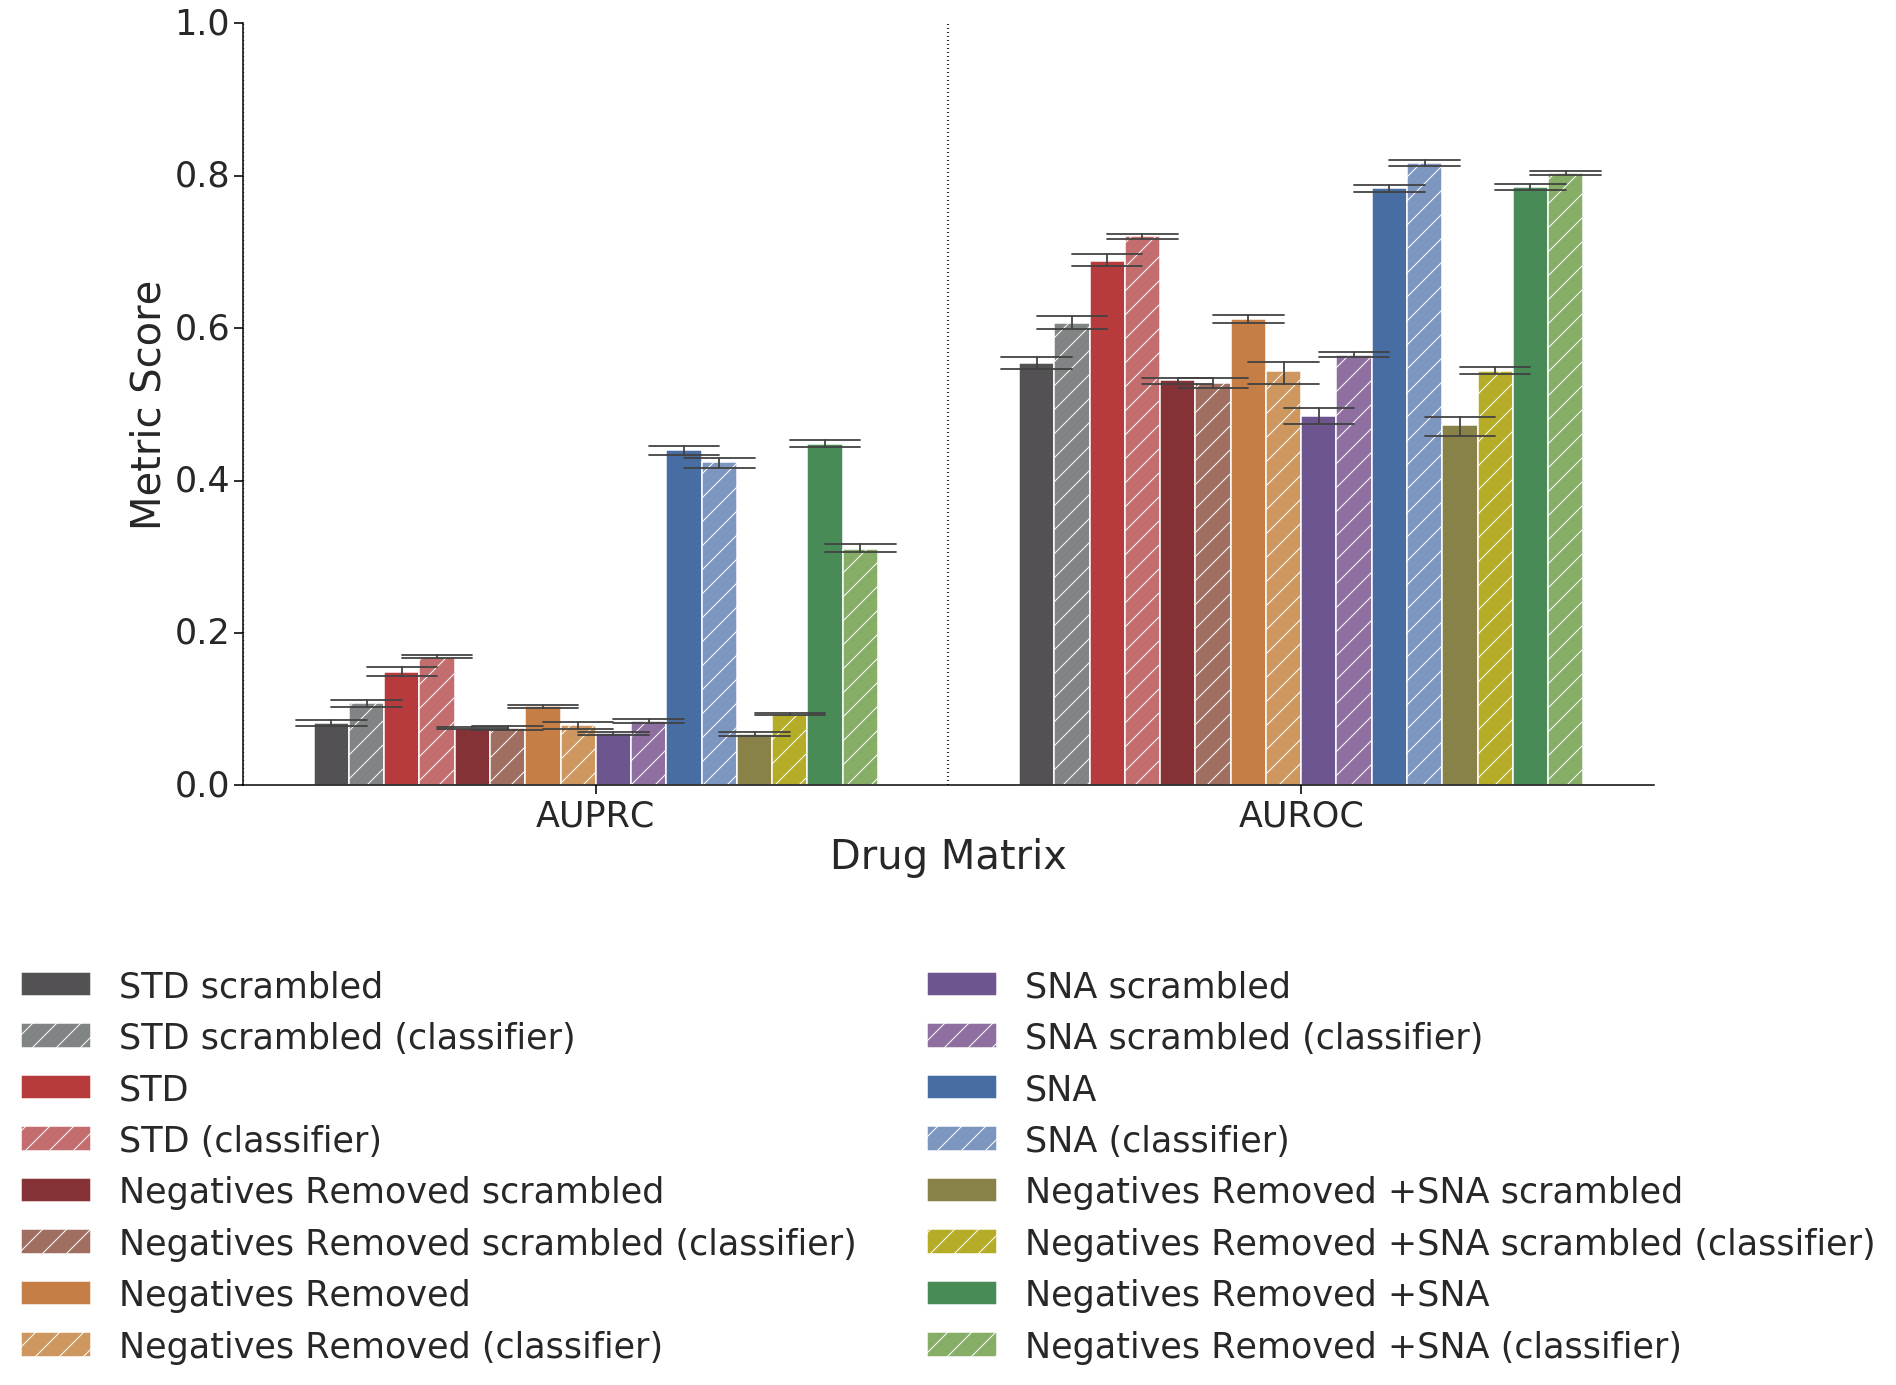

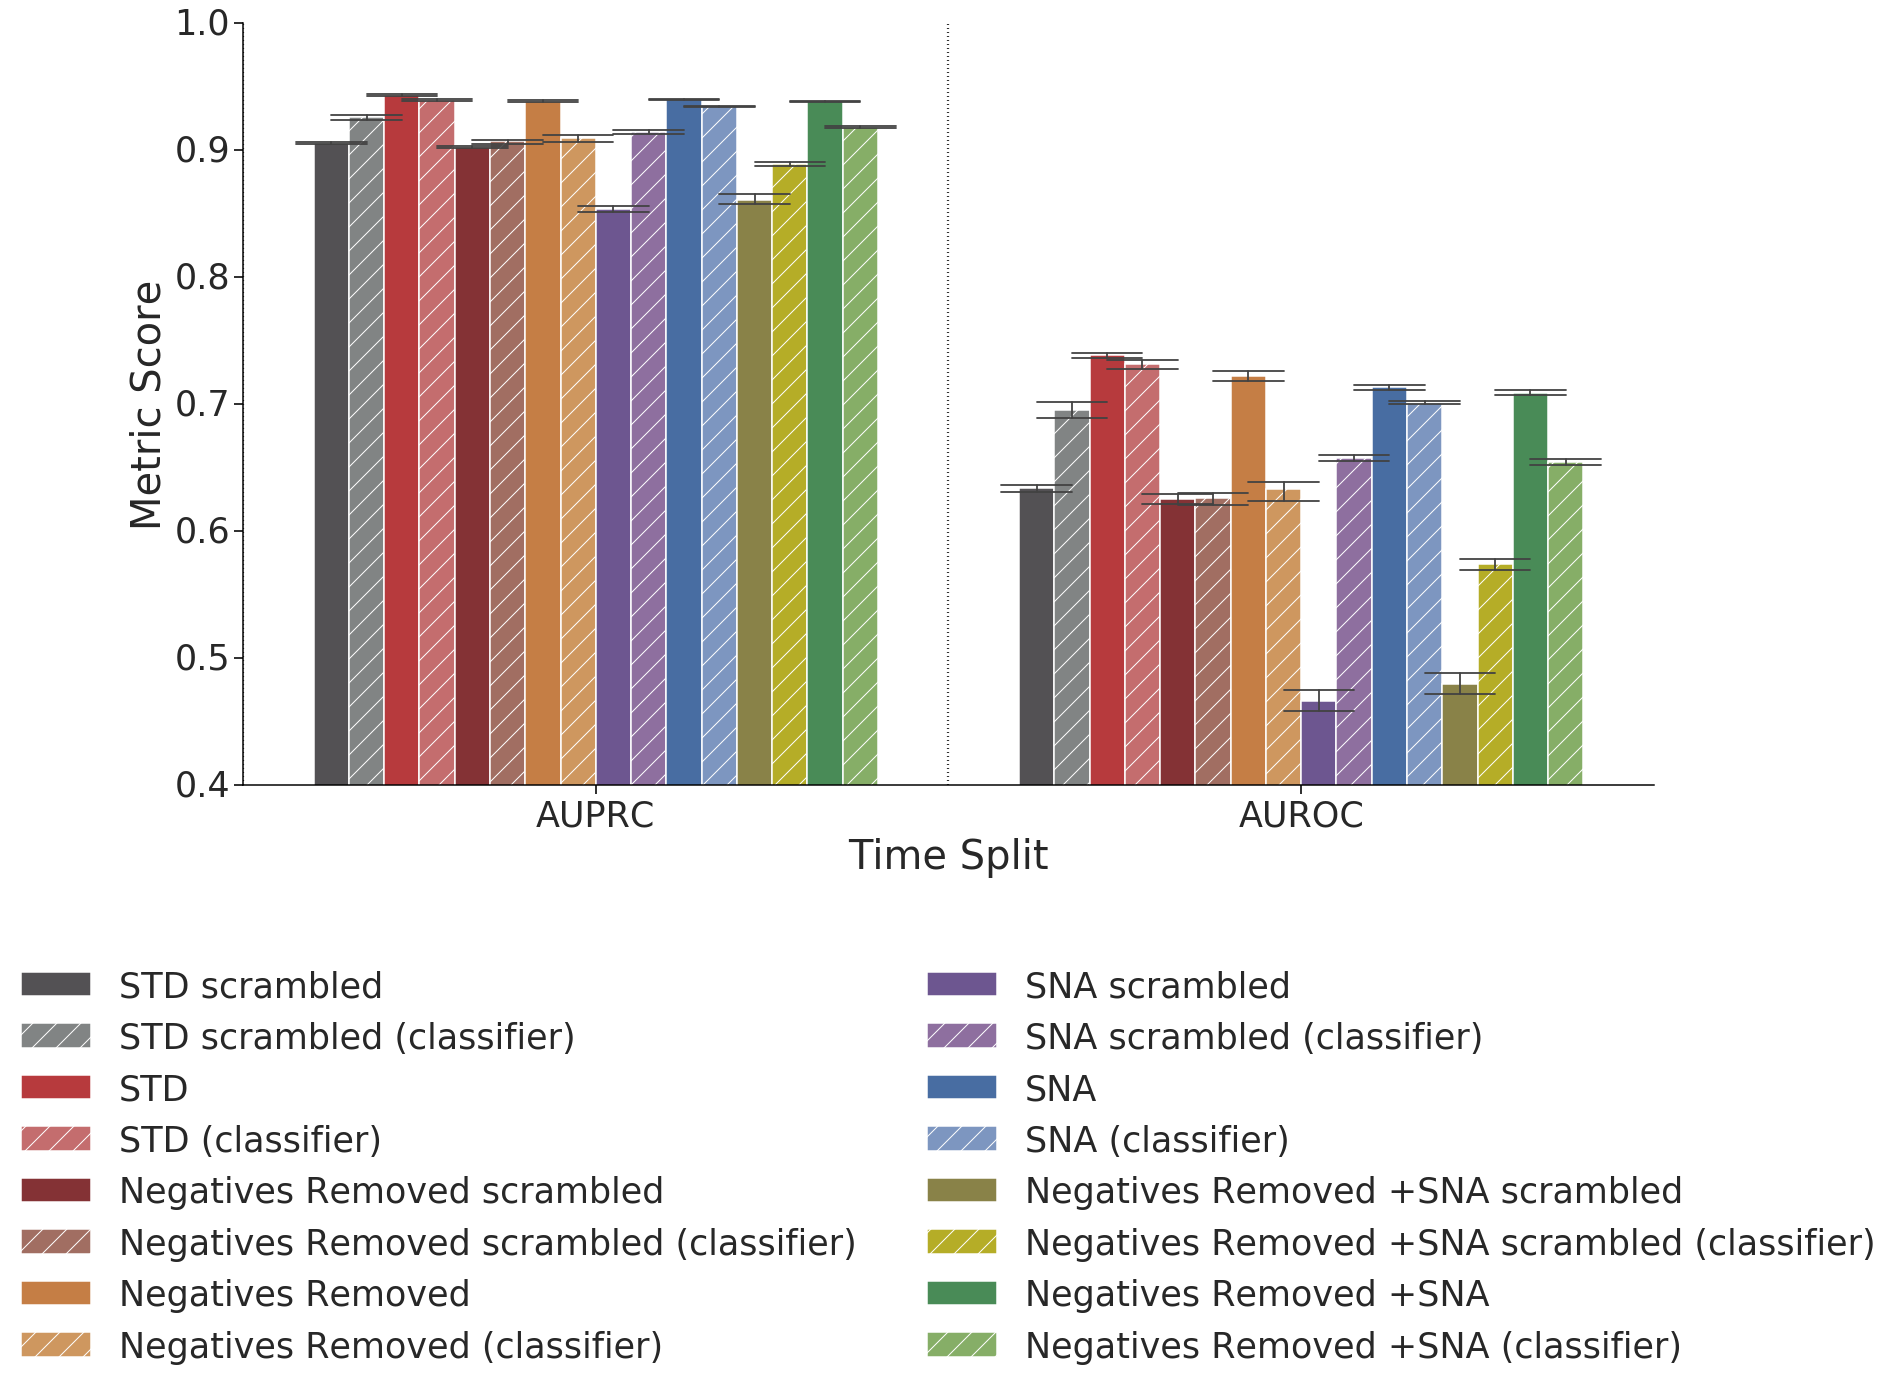

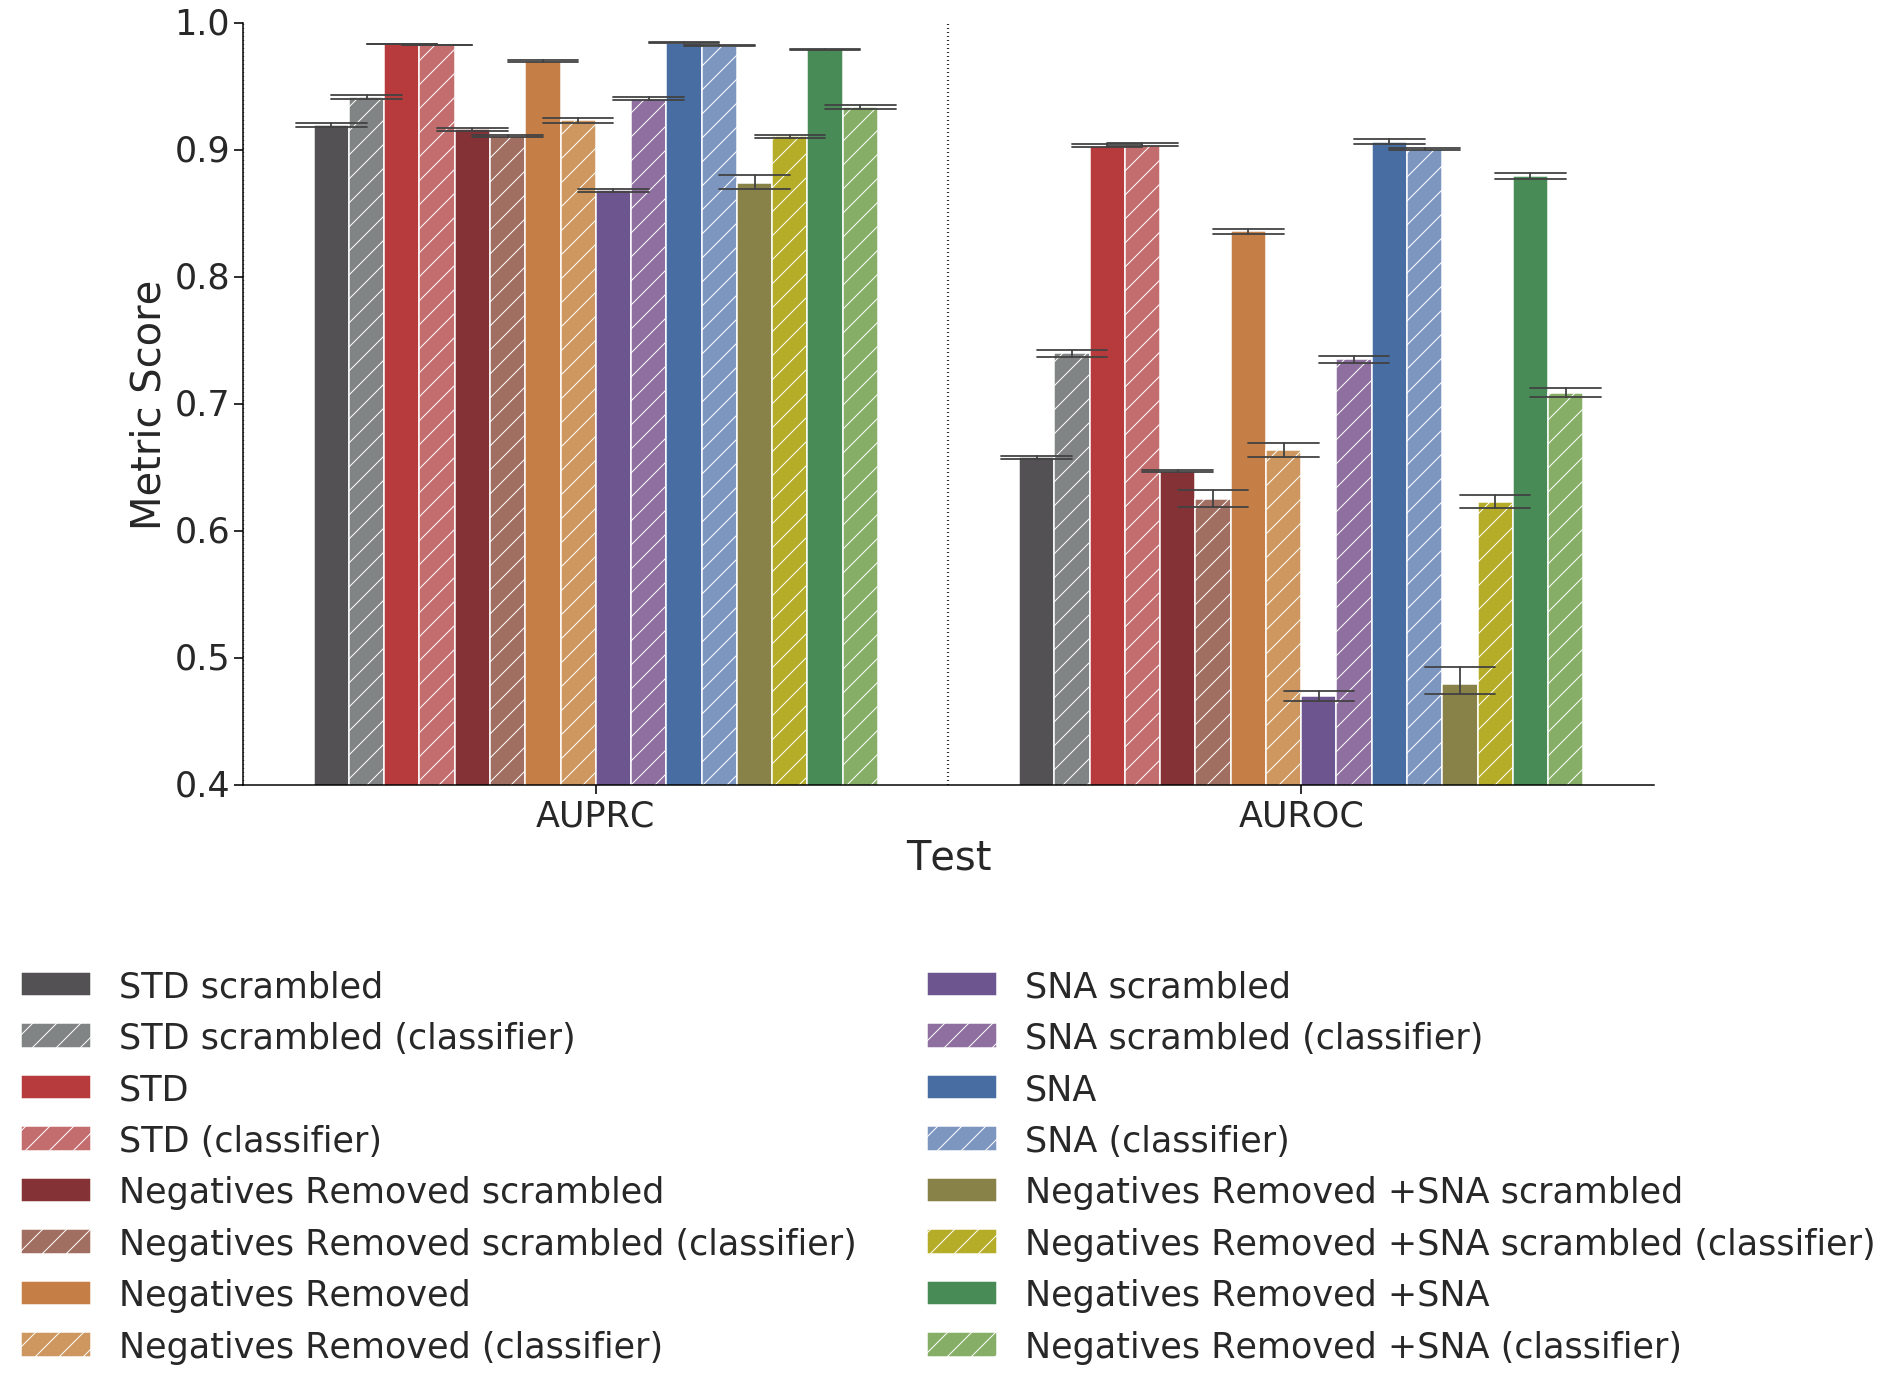

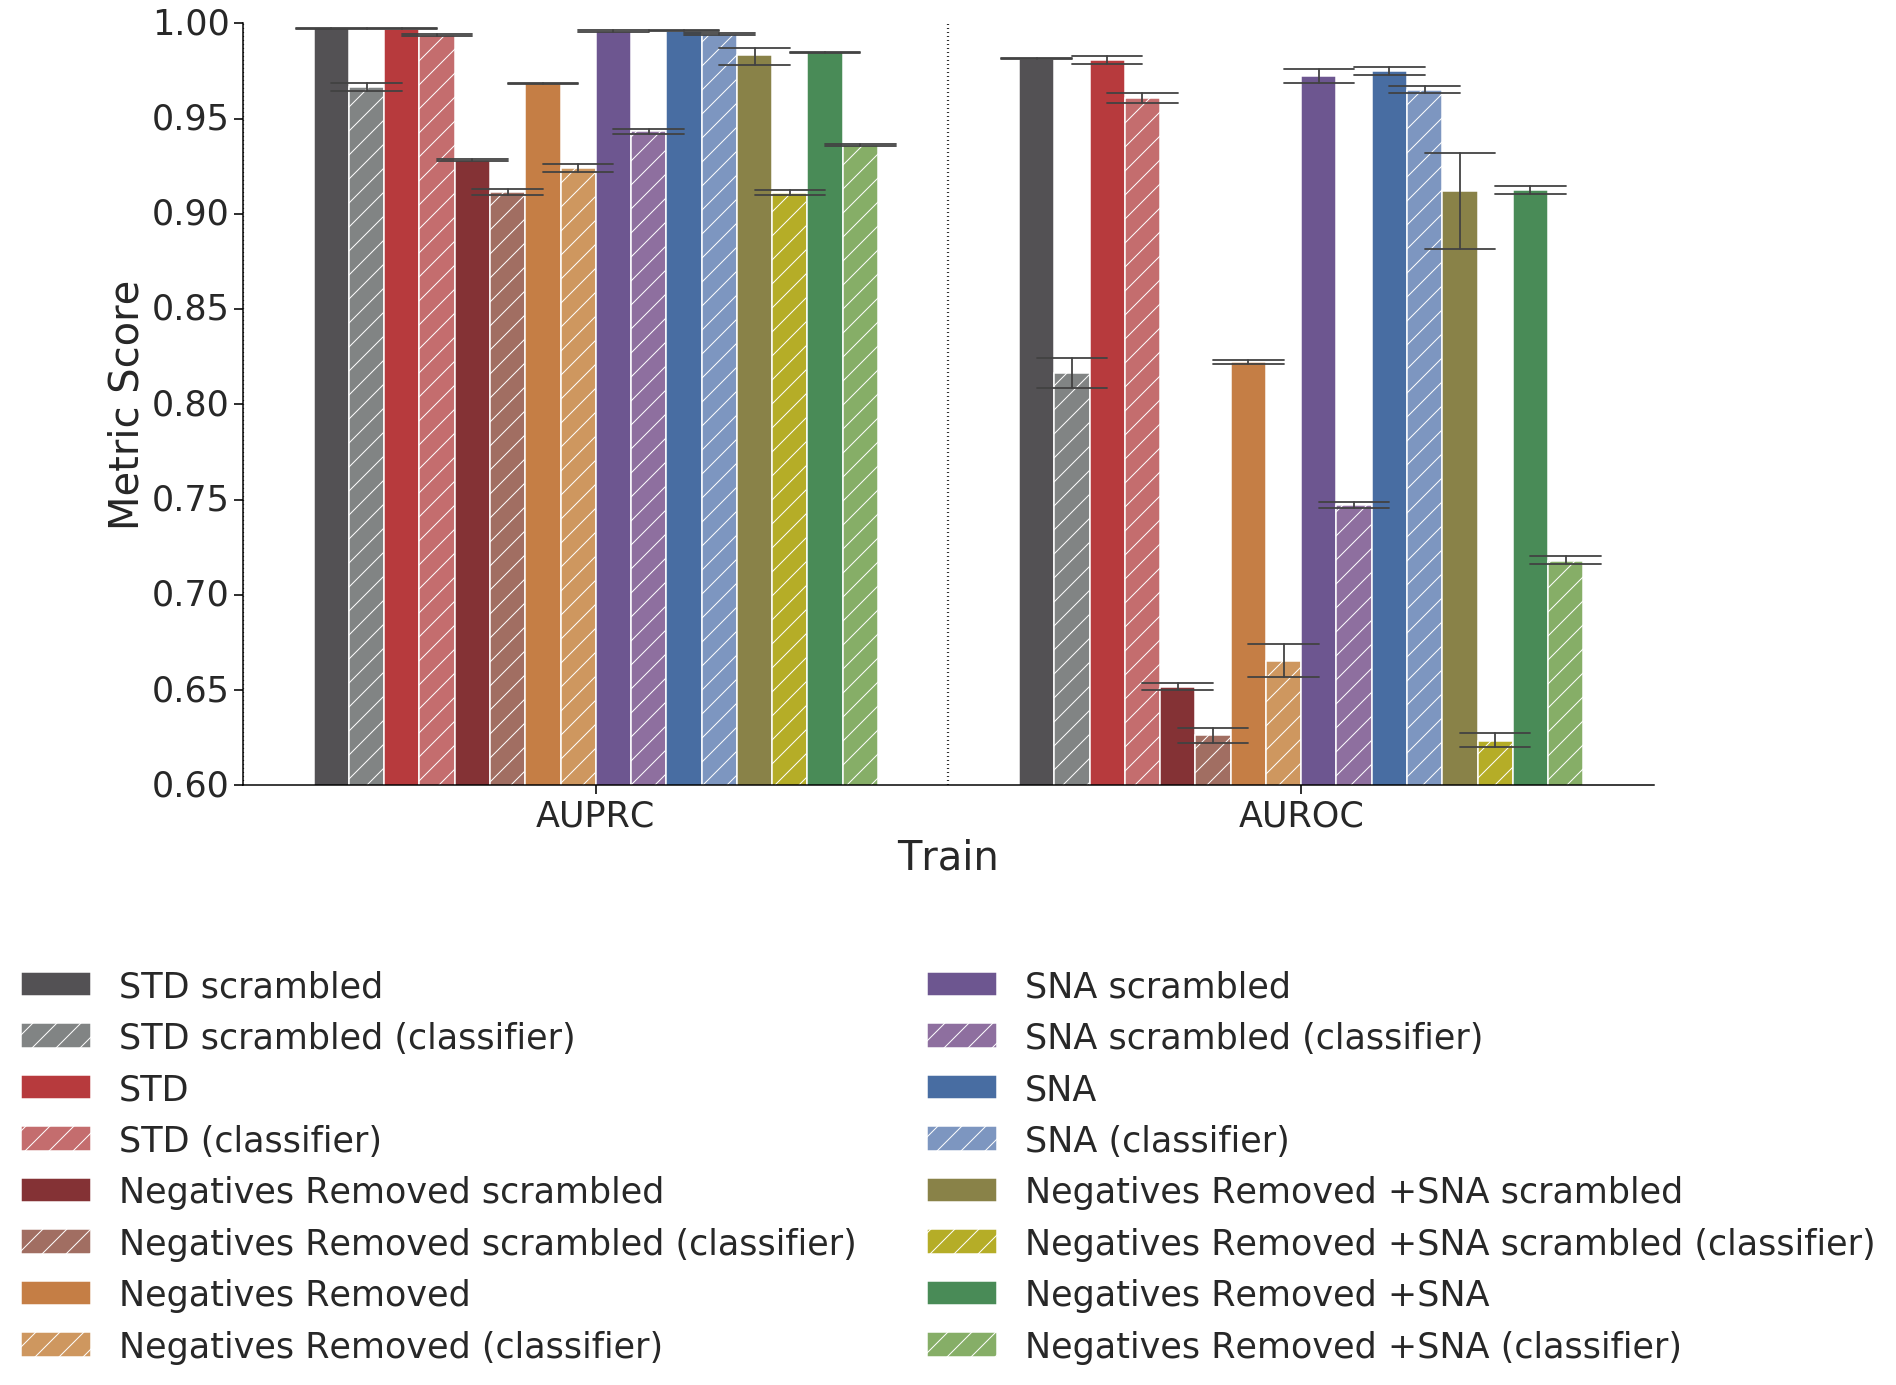

In [24]:
sns.set(style="white")
sns.set_context("talk")
amt = 1.5

expts=['scrambled_idx_no_SMA_LC', 'CLASSIFIER_scrambled_idx_No_SMA_LC', 
       'STD', 'CLASSIFIER_STD',
       'NEG_RM_scrambled', 'CLASSIFIER_NEG_RM_scrambled',
       'NEG_RM', 'CLASSIFIER_NEG_RM',
       'scrambled_idx_LC', 'CLASSIFIER_scrambled_idx_LC',
       'STD_SMA', 'CLASSIFIER_SMA_RATIOS',
       "NEG_RM_RATIOS_scrambled", "CLASSIFIER_NEG_RM_RATIOS_scrambled",
       'NEG_RM_SMA', 'CLASSIFIER_NEG_RM_SMA_RATIOS', 
#        'SEA_SMA', 'CLASSIFIER_SEA_SMA',
]

new_df = df.copy()
new_df = rename_vals(new_df, expt_lookup_dict=expt_legend_lookup)

expt_names = [expt_legend_lookup[i] for i in expts]

for dset in new_df.dset.unique():
    
    legend = True
    new_palette= []
    
    for i in expts:
        if "CLASSIFIER" in i:
            new_palette.append(color_dict_bar[expt_color_lookup[i]])
        else:
            new_palette.append(color_dict_pt[expt_color_lookup[i]])
            
    tmp_df = new_df[new_df["dset"] == dset].copy()
    tmp_df = tmp_df.pivot_table(columns=["expt", "dset", "fold"]).reset_index()
    tmp_df.columns = ["metric", "expt", "dset", "fold", "value"]
    g = sns.catplot(x="metric", y="value", hue="expt", hue_order=expt_names, data=tmp_df, kind="bar", 
                    palette=new_palette, orient="v", legend=False, legend_out=True, height = 12, aspect=1.75, 
                    **{"capsize":0.1, "errwidth":1.8})

    # set the fancy spines
    (g.despine(right=True)
    .set_xlabels(dset, fontsize=titlesize)
    .set_ylabels("Metric Score")
    .ax.tick_params(top=False, right=False)
    )
    
    g.ax.spines["left"].set_visible(True)
    g.ax.spines["left"].set_color("black")
    g.ax.spines["left"].set_linewidth(1.5)
    g.ax.spines["bottom"].set_visible(True)
    g.ax.spines["bottom"].set_color("black")
    g.ax.spines["bottom"].set_linewidth(1.5)
    
    g.ax.yaxis.label.set_size(titlesize)
    g.ax.xaxis.label.set_size(titlesize)
    g.ax.set_ylim(dset_ymin_lookup[dset], 1)
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelsize=labelsize) 
    plt.tick_params(axis='y', which='both', left=True, right=False, labelsize=labelsize) 
    
    # set the ylim
    line_offset=0
    lower, upper = g.ax.get_xbound()

    for i in np.arange(lower, upper, 1):
        g.ax.axvline(i, ls=":", c=".2")
        
    hatch = [ "", "", "/", "/"]*len(expts)
    leg_artists = []

    for i,thisbar in enumerate(g.ax.patches):
        # Set a different hatch for each bar
        thisbar.set_hatch(hatch[i])
        
    legend=plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False, fontsize=labelsize)
    
    plt.savefig("{}/{}_STD_SNA_NEGRM_reg_class_bar_plots.png".format(save_dir, dset), dpi=100, 
                bbox_extra_artists=[legend,], bbox_inches="tight")
    plt.show()
    plt.clf()
    
    

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/home/ecaceres/anaconda2/envs/features/lib/pyth

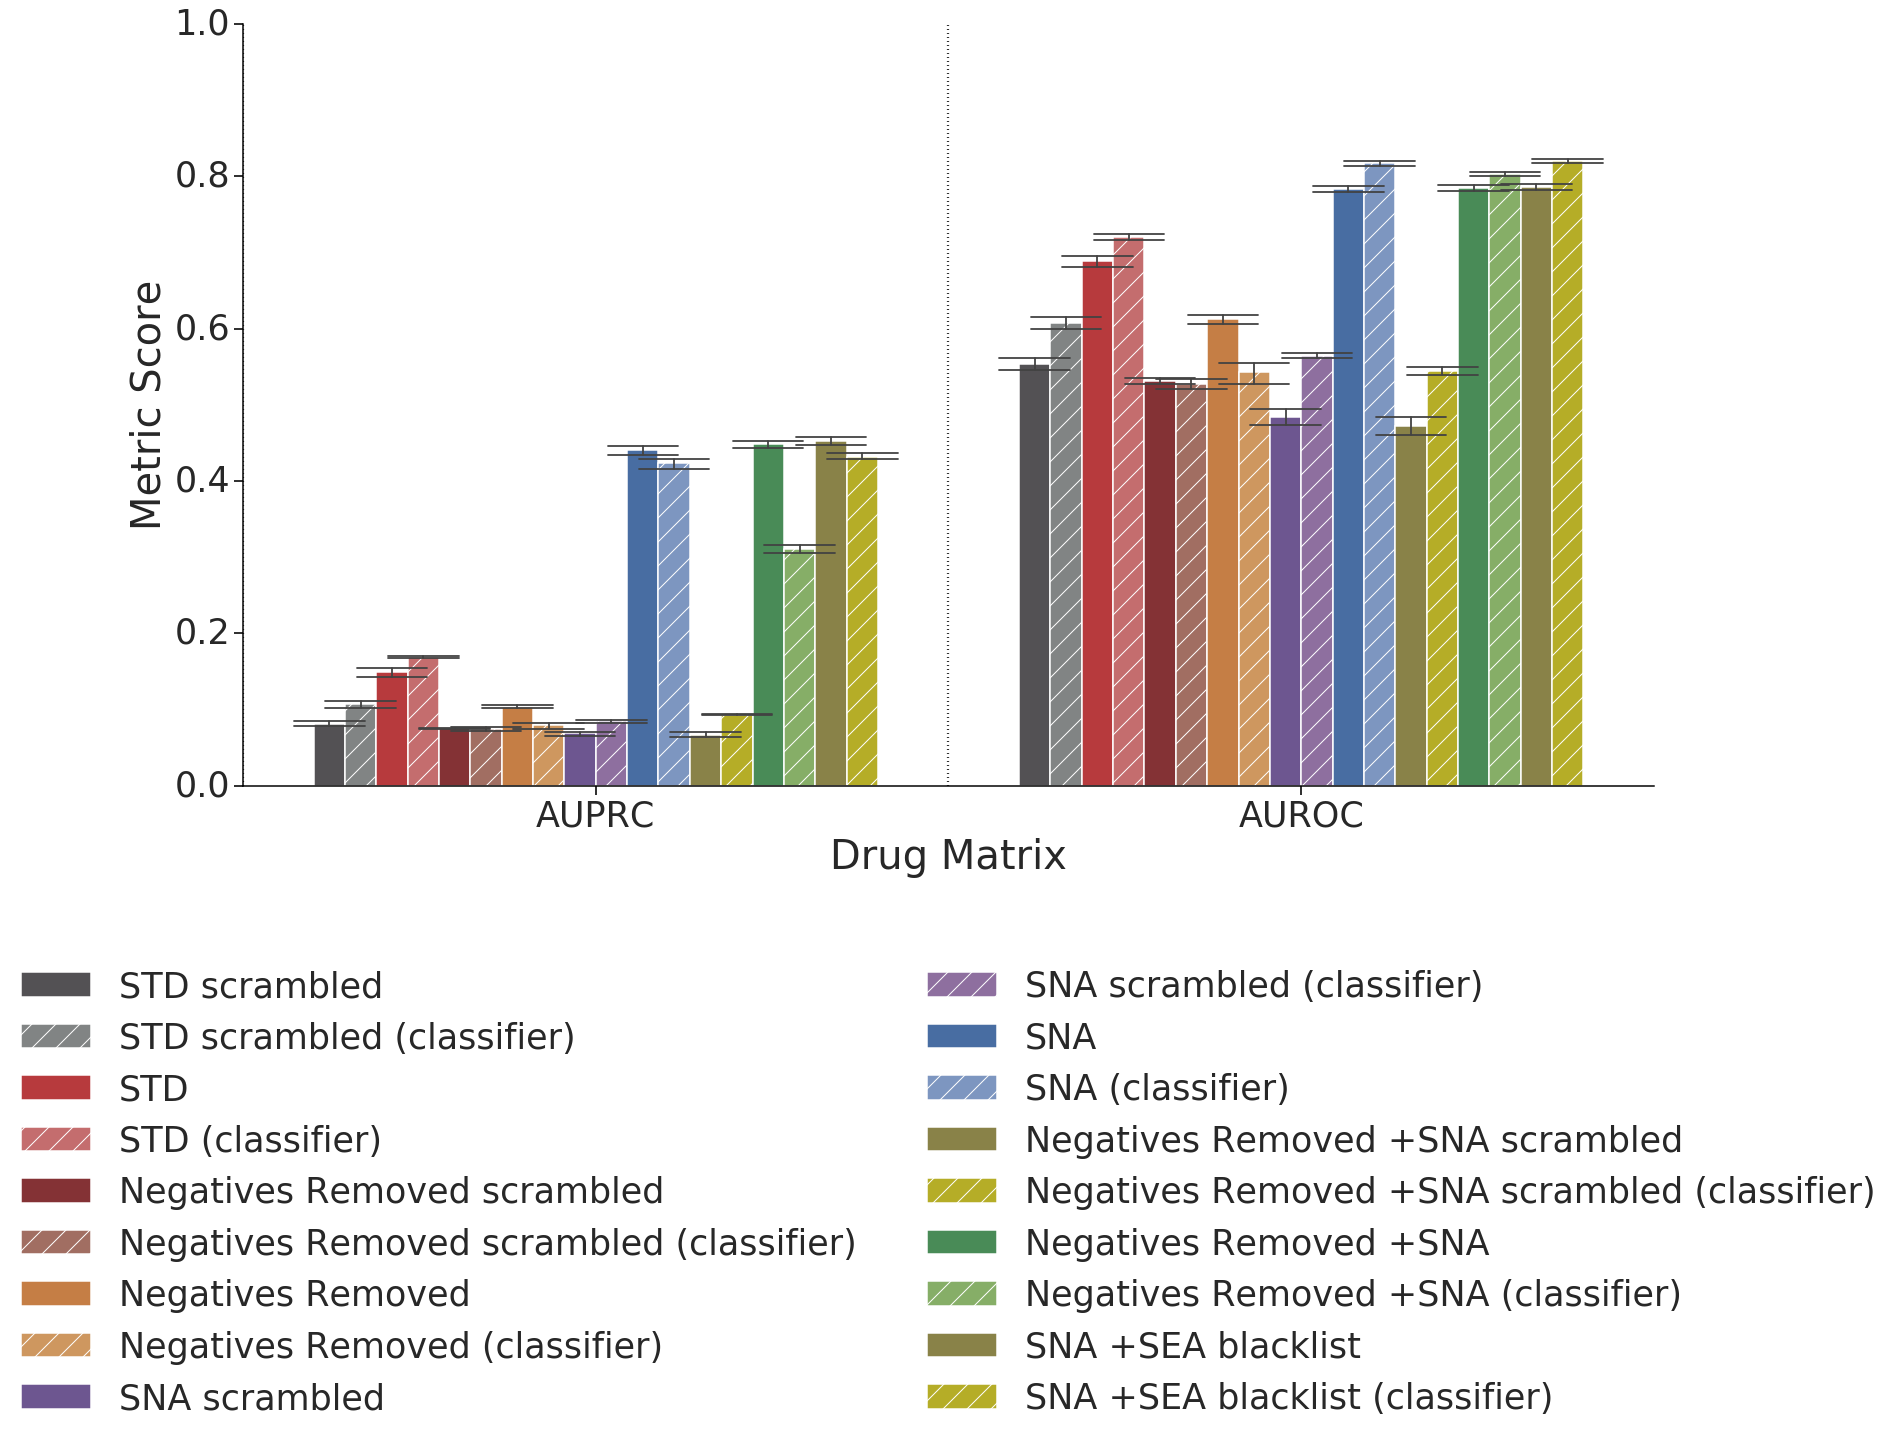

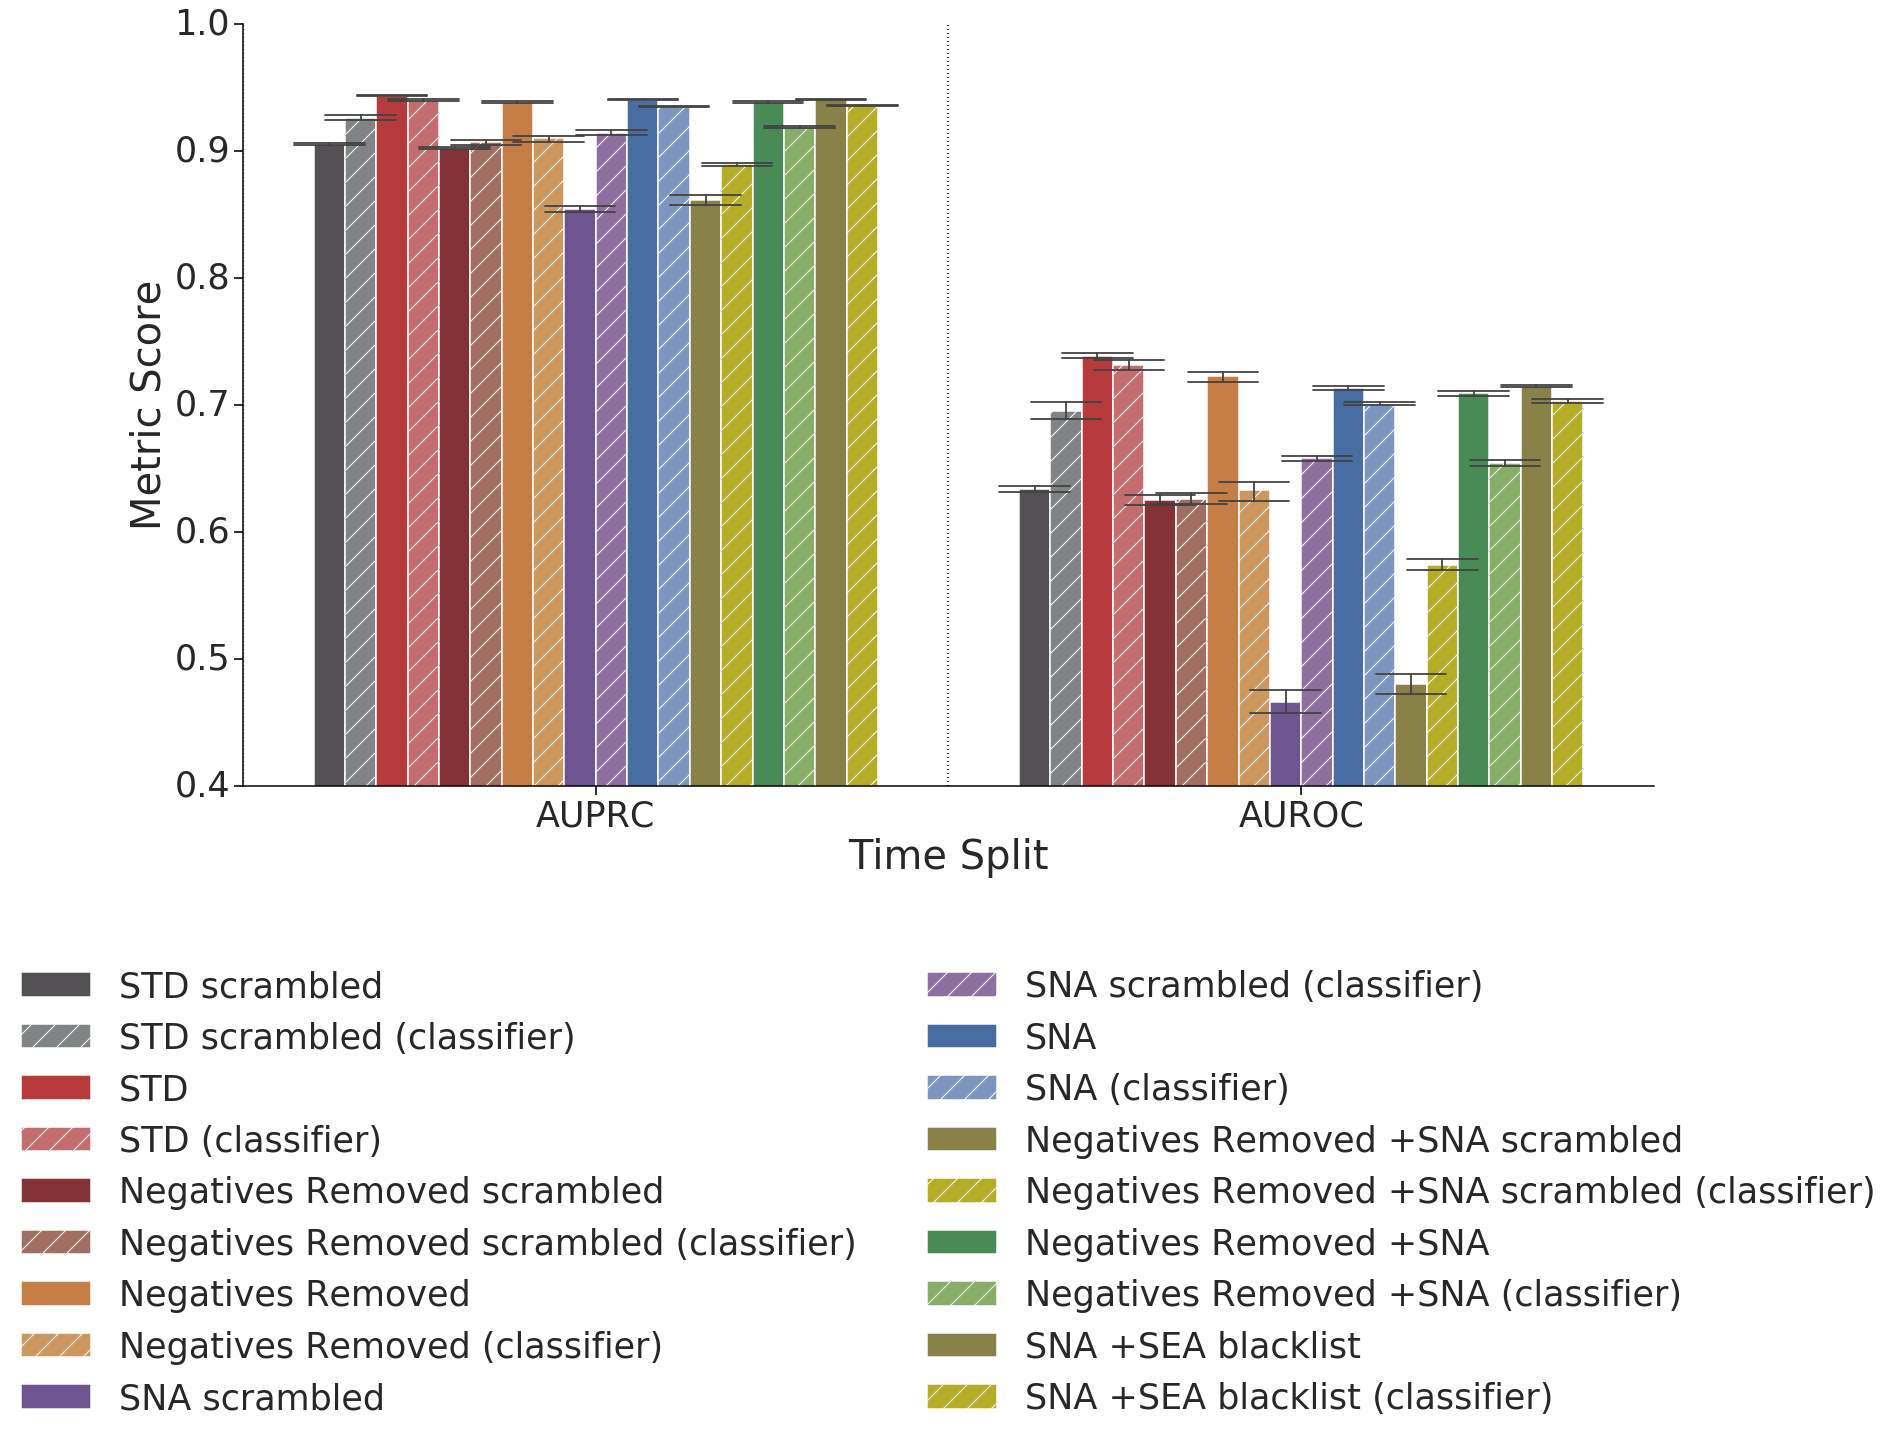

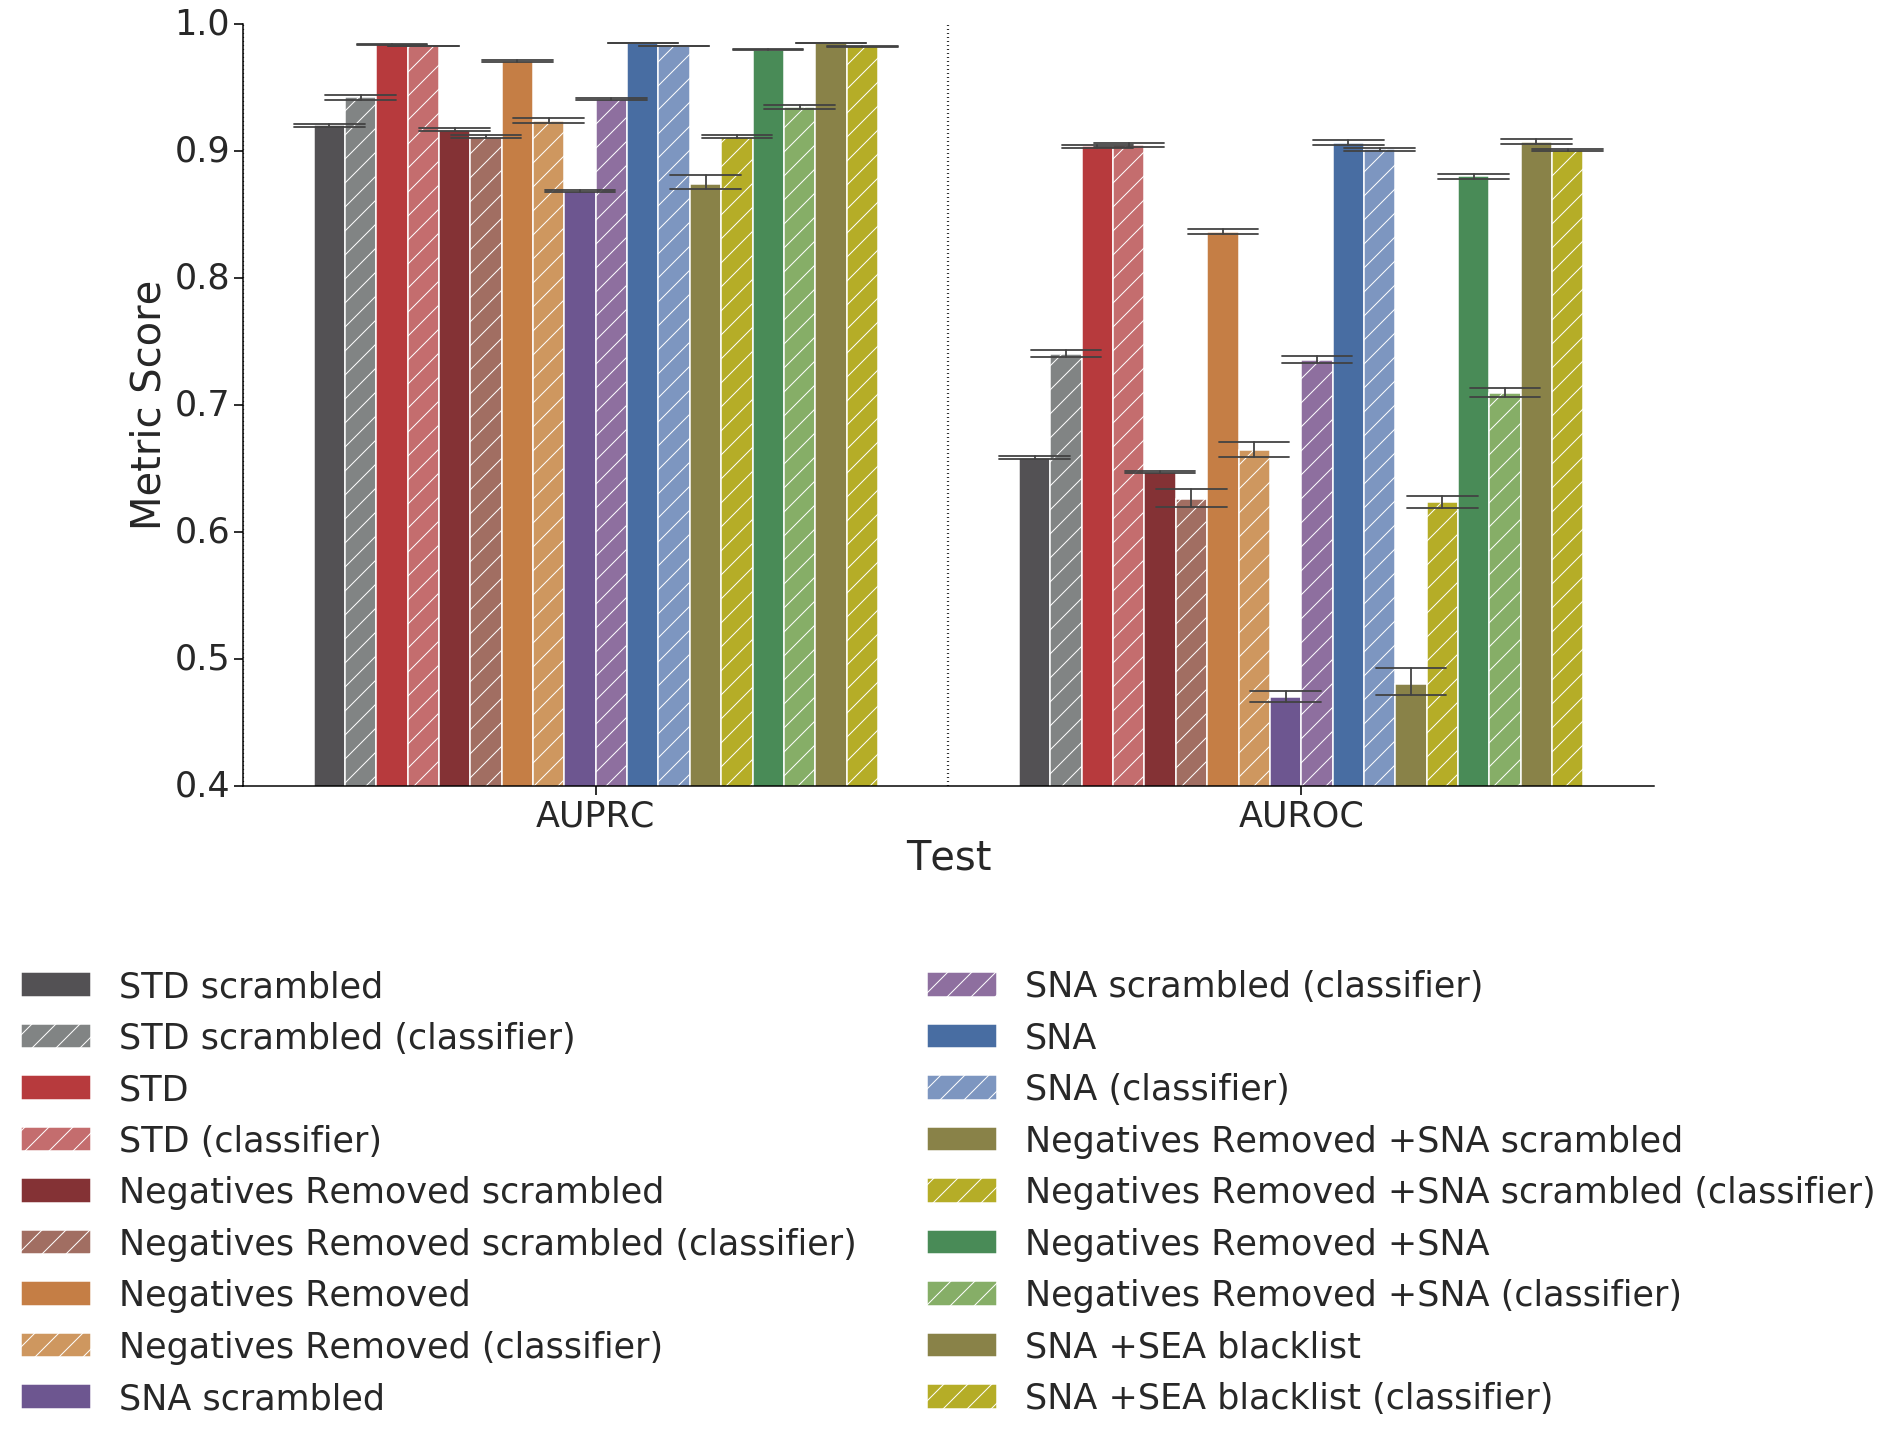

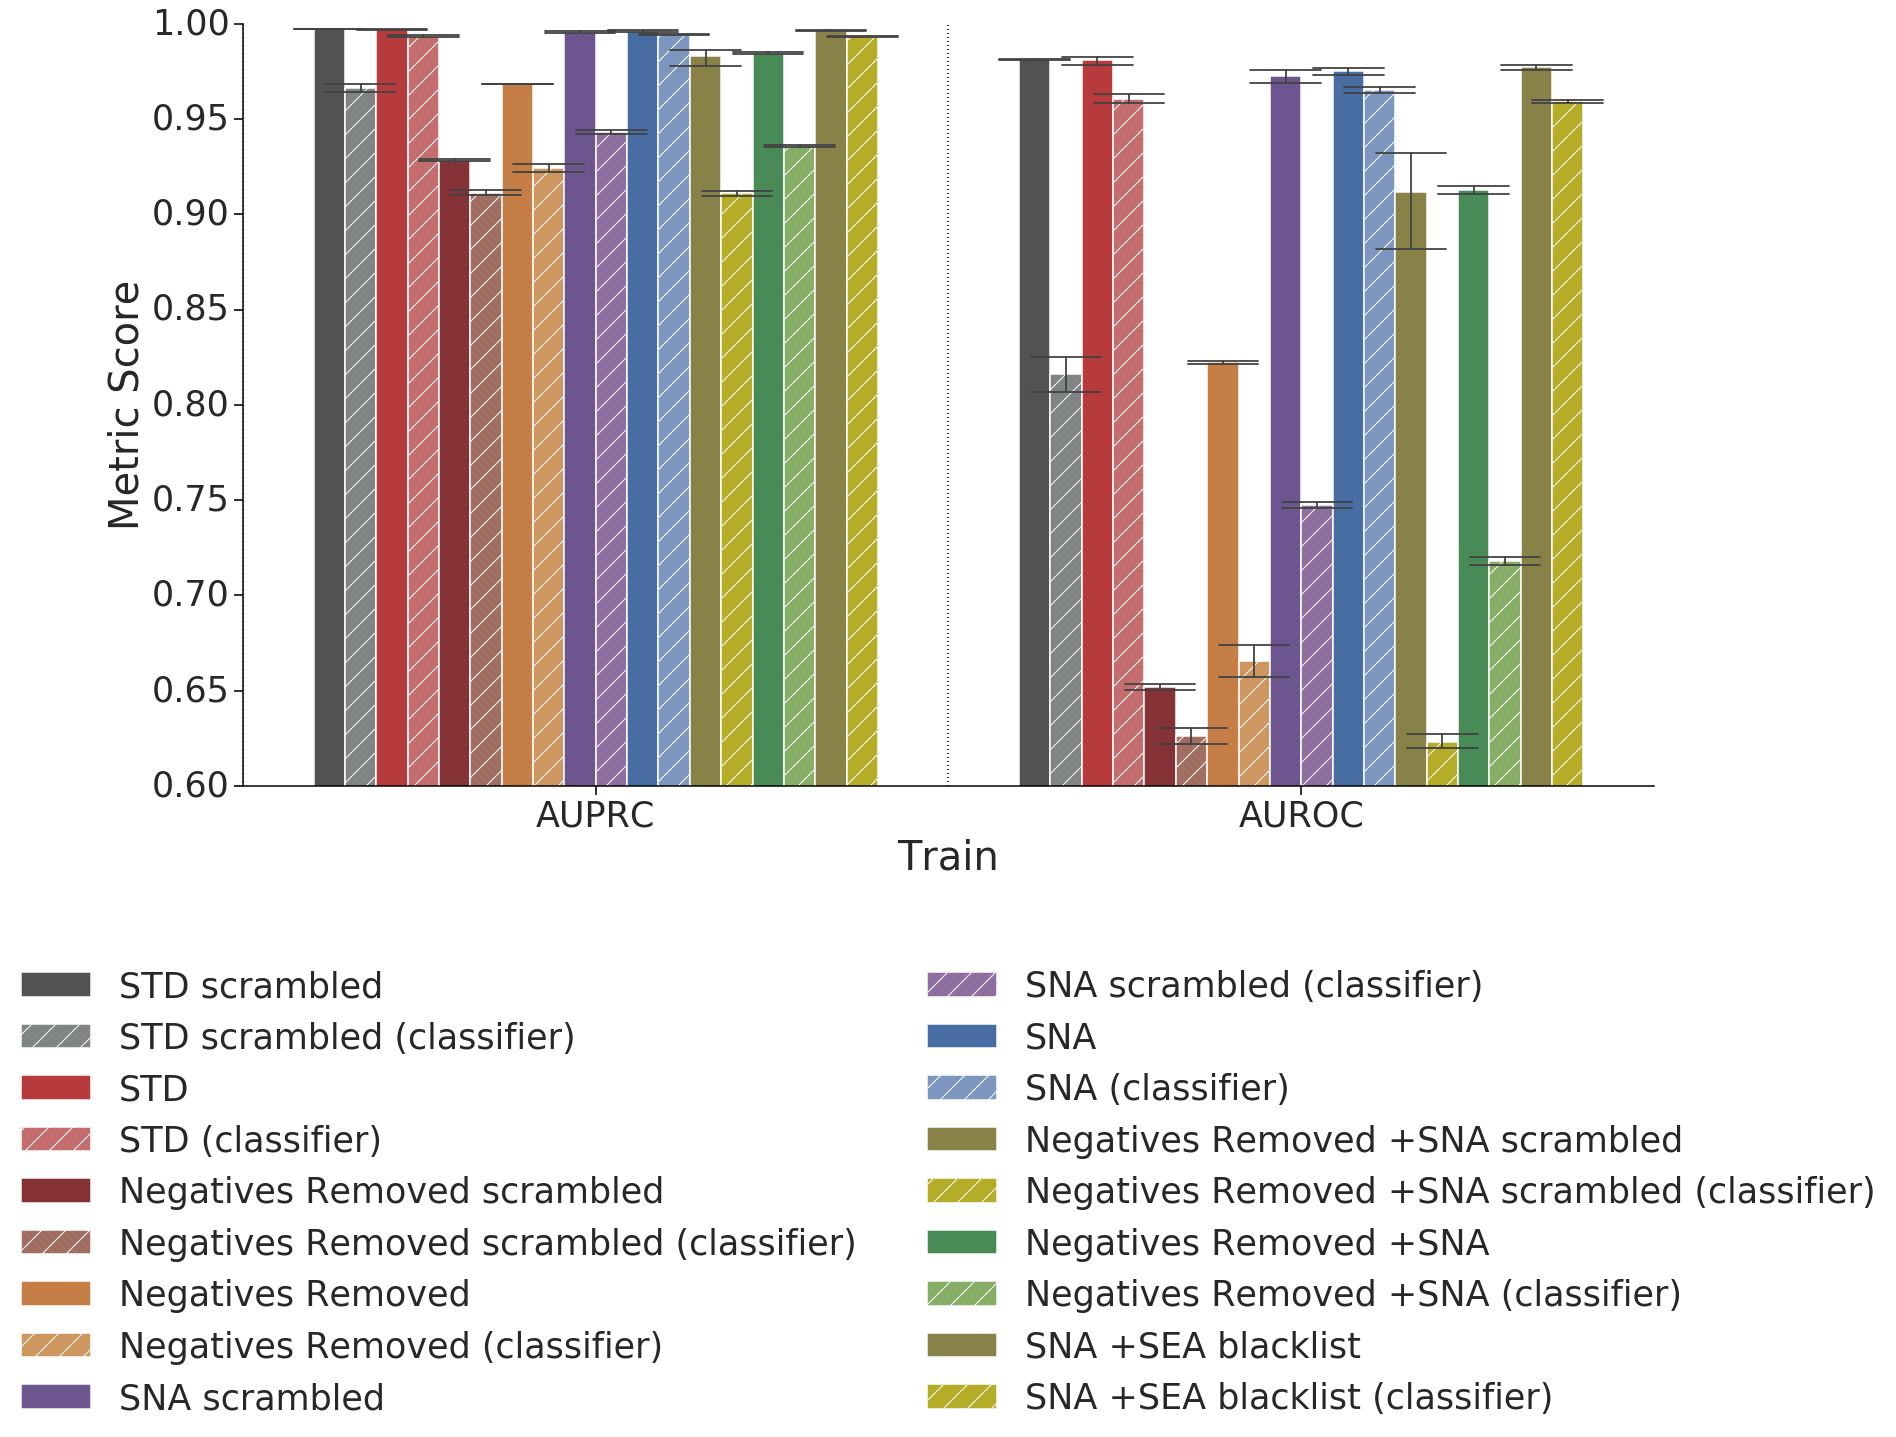

In [25]:
sns.set(style="white")
sns.set_context("talk")
amt = 1.5

expts=['scrambled_idx_no_SMA_LC', 'CLASSIFIER_scrambled_idx_No_SMA_LC', 
       'STD', 'CLASSIFIER_STD',
       'NEG_RM_scrambled', 'CLASSIFIER_NEG_RM_scrambled',
       'NEG_RM', 'CLASSIFIER_NEG_RM',
       'scrambled_idx_LC', 'CLASSIFIER_scrambled_idx_LC',
       'STD_SMA', 'CLASSIFIER_SMA_RATIOS',
       "NEG_RM_RATIOS_scrambled", "CLASSIFIER_NEG_RM_RATIOS_scrambled",
       'NEG_RM_SMA', 'CLASSIFIER_NEG_RM_SMA_RATIOS', 
       'SEA_SMA', 'CLASSIFIER_SEA_SMA',
]

new_df = df.copy()
new_df = rename_vals(new_df, expt_lookup_dict=expt_legend_lookup)

expt_names = [expt_legend_lookup[i] for i in expts]

for dset in new_df.dset.unique():
    
    legend = True
    new_palette= []
    
    for i in expts:
        if "CLASSIFIER" in i:
            new_palette.append(color_dict_bar[expt_color_lookup[i]])
        else:
            new_palette.append(color_dict_pt[expt_color_lookup[i]])
            
    tmp_df = new_df[new_df["dset"] == dset].copy()
    tmp_df = tmp_df.pivot_table(columns=["expt", "dset", "fold"]).reset_index()
    tmp_df.columns = ["metric", "expt", "dset", "fold", "value"]
    g = sns.catplot(x="metric", y="value", hue="expt", hue_order=expt_names, data=tmp_df, kind="bar", 
                    palette=new_palette, orient="v", legend=False, legend_out=True, height = 12, aspect=1.75, 
                    **{"capsize":0.1, "errwidth":1.8})

    # set the fancy spines
    (g.despine(right=True)
    .set_xlabels(dset, fontsize=titlesize)
    .set_ylabels("Metric Score")
    .ax.tick_params(top=False, right=False)
    )
    
    g.ax.spines["left"].set_visible(True)
    g.ax.spines["left"].set_color("black")
    g.ax.spines["left"].set_linewidth(1.5)
    g.ax.spines["bottom"].set_visible(True)
    g.ax.spines["bottom"].set_color("black")
    g.ax.spines["bottom"].set_linewidth(1.5)
    
    g.ax.yaxis.label.set_size(titlesize)
    g.ax.xaxis.label.set_size(titlesize)
    g.ax.set_ylim(dset_ymin_lookup[dset], 1)
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelsize=labelsize) 
    plt.tick_params(axis='y', which='both', left=True, right=False, labelsize=labelsize) 
    
    # set the ylim
    line_offset=0
    lower, upper = g.ax.get_xbound()

    for i in np.arange(lower, upper, 1):
        g.ax.axvline(i, ls=":", c=".2")
        
    hatch = [ "", "", "/", "/"]*len(expts)
    leg_artists = []

    for i,thisbar in enumerate(g.ax.patches):
        # Set a different hatch for each bar
        thisbar.set_hatch(hatch[i])
        
    legend=plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False, fontsize=labelsize)
    
    plt.savefig("{}/{}_STD_SNA_NEGRM_SEA_reg_class_bar_plots.png".format(save_dir, dset), dpi=100, 
                bbox_extra_artists=[legend,], bbox_inches="tight")
    plt.show()
    plt.clf()
    